In [2]:
# Импортируем необходимые библиотеки

import numpy as np                                      # для работы с массивами данных
import pandas as pd                                     # для обработки и анализа данных (чтобы красиво смотрелись таблички)
import seaborn as sns                                   # для визуализации
import xlrd                                             # для чтения Excel-файлов

from sklearn.preprocessing import StandardScaler        # для стандартизации данных (приведение к нормальному распределению)

from sklearn.model_selection import train_test_split    # для разделения на тестовую о обучающую выборки
from sklearn.metrics import r2_score                    # для оценки качества машинного обучения 

from sklearn.linear_model import Ridge                  # алгоритм машинного обучения
from sklearn.ensemble import RandomForestRegressor      # алгоритм машинного обучения
from sklearn.ensemble import GradientBoostingRegressor  # алгоритм машинного обучения
from sklearn.neural_network import MLPRegressor         # алгоритм машинного обучения (нейронная сеть)

import matplotlib.pyplot as plt                         # для визуализации
%matplotlib inline                                      

## 1. Предварительная обработка датасета

In [8]:
dataset = pd.read_excel('ebw_data.xlsx')                # загружаем датасет
dataset.head()                                          # смотрим первые 5 значений сверху

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48


In [9]:
dataset.shape                                          # смотрим размер датасета: 72 строки, 6 колонок

(72, 6)

In [10]:
dataset.isnull().sum()                                # смотрим количествто пропущенных значений. Их нет, и слава богу.
                                                      # а то пришлось бы их удалять или заполнять. Но нам повезло.

IW       0
IF       0
VW       0
FP       0
Depth    0
Width    0
dtype: int64

In [11]:
dataset.nunique()                                     # смотрим количество уникальных значений. Считаю, что тоже повезло
                                                      # если бы где-то было 2, пришлось бы применять что-то типа LabelEncoder или OneHotEncoder

IW        7
IF        8
VW        5
FP        5
Depth    29
Width    25
dtype: int64

<AxesSubplot:>

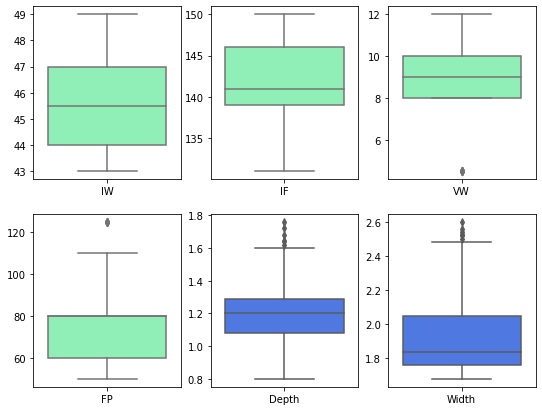

In [12]:
plt.figure(figsize=(9, 7))                             # построим "ящики с усами" для анализа выбросов и аномалий

pal1 = sns.color_palette('rainbow', 1)                 # для наглядности пусть входные параметры будут одного цвета
sns.set_palette(pal1)
plt.subplot(2, 3, 1)
sns.boxplot(data=dataset[['IW']])
plt.subplot(2, 3, 2)
sns.boxplot(data=dataset[['IF']])
plt.subplot(2, 3, 3)
sns.boxplot(data=dataset[['VW']])
plt.subplot(2, 3, 4)
sns.boxplot(data=dataset[['FP']])

pal2 = sns.color_palette('rainbow', 6)                  # а выходные параметры - другого цвета
sns.set_palette(pal2)
plt.subplot(2, 3, 5)
sns.boxplot(data=dataset[['Depth']])
plt.subplot(2, 3, 6)
sns.boxplot(data=dataset[['Width']])

#Как мы видим, боксплоты показывают, что у нас существуют некоторые отклонения в у VW, FP, Depth и Width. 
# Но можно ли считать это аномалиями/выбросами?

In [13]:
dataset.describe()                                   # выведем описательную статистику датасета

# После анализа описательной статистики я принимаю решение, что в датасете отсутствуют аномалии и выбросы,
# т.к. не такой уж и сильный там разброс.
# Кроме того, у нас такой маленький датасет, что мы не можем просто так взять и выкинуть какие-то значения.

,IW,IF,VW,FP,Depth,Width
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,45.666667,141.333333,8.638889,78.333333,1.195556,1.970417
std,1.678363,5.145763,2.061078,21.493530,0.225081,0.279040
min,43.000000,131.000000,4.500000,50.000000,0.800000,1.680000
25%,44.000000,139.000000,8.000000,60.000000,1.080000,1.760000
50%,45.500000,141.000000,9.000000,80.000000,1.200000,1.840000
75%,47.000000,146.000000,10.000000,80.000000,1.290000,2.050000
max,49.000000,150.000000,12.000000,125.000000,1.760000,2.600000


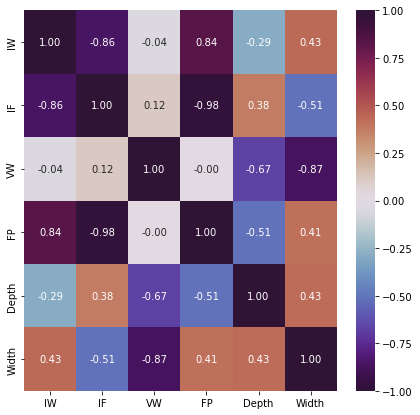

In [14]:
# построим "тепловую" карту, чтобы посмотреть зависимости параметров друг от друга

corr = dataset.corr()
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='twilight_shifted', ax=ax)
plt.show()

Ура! В некоторых случаях зависимости очевидно выражены.

Далее выполним стандартизацию данных.

"Почему ты использовала этот метод", - спросите Вы.

А я отвечу: "Потому что консультировалась у экспертов".

Статья "Модель анализа и прогнозирования технологических параметров для процесса электронно-лучевой сварки": https://cyberleninka.ru/article/n/model-analiza-i-prognozirovaniya-tehnologicheskih-parametrov-dlya-protsessa-elektronno-luchevoy-svarki

Там я увидела знакомые слова, типа StandardScaler, и решила, что не буду изобретать велосипед.

In [15]:
std_scaler = StandardScaler()                                                         # вызываем метод
dataset_std = std_scaler.fit_transform(np.array(dataset[['IW', 'IF', 'VW', 'FP']]))   # обучаем нормализатор
dataset_std[:1]                                                                       # смотрим первую строчку

array([[ 0.8       , -0.45662965, -2.02221044,  0.07808688]])

In [16]:
# вернём из np.array обратно в DataFrame 
# в видеолекции "Нормализация и стандартизация, практика" Г.В. Соколов так делал, и мы тоже будем

dataset_std_df = pd.DataFrame(data = dataset_std, columns = ['IW', 'IF', 'VW', 'FP'])
dataset_std_df.head()

,IW,IF,VW,FP
0,0.8,-0.456630,-2.02221,0.078087
1,0.8,-0.456630,-2.02221,0.078087
2,0.8,-0.456630,-2.02221,0.078087
3,0.8,-0.456630,-2.02221,0.078087
4,-0.4,-0.260931,-2.02221,0.078087


In [17]:
dataset_std_df.describe()                                     # выведем описательную статистику датасета после стандартизации

,IW,IF,VW,FP
count,7.200000e+01,7.200000e+01,7.200000e+01,7.200000e+01
mean,1.437122e-15,-1.844204e-15,-6.784696e-17,3.361509e-16
std,1.007018e+00,1.007018e+00,1.007018e+00,1.007018e+00
min,-1.600000e+00,-2.022217e+00,-2.022210e+00,-1.327477e+00
25%,-1.000000e+00,-4.566297e-01,-3.121533e-01,-8.589557e-01
50%,-1.000000e-01,-6.523281e-02,1.764345e-01,7.808688e-02
75%,8.000000e-01,9.132593e-01,6.650222e-01,7.808688e-02
max,2.000000e+00,1.696053e+00,1.642198e+00,2.186433e+00


## 2. Применение минимум 3-х алгоритмов машинного обучения (включая обязательно использование искусственных нейронных сетей) в Jupyter Notebook (или colab) позволяющих решить поставленную задачу анализа данных, выбрать лучшую модель и применить ее в приложении

In [18]:
# Зависимость глубины сварных швов от совокупности параметров технологических режимов 

y1_columns = ['Depth']                                                 # это наши выходные значения №1
x1_columns = ['IW', 'IF', 'VW', 'FP']                                  # это наши входные значения

y1 = dataset.loc[:, y1_columns]                                        # выходные значения берём из "оригинального" датасета
x1 = dataset_std_df.loc[:, x1_columns]                                 # входные значения берём из стандартизированного датасета

# разделяем выборку на тестовую и обучающую
# с параметрами поигрались, чтобы достичь нормальных показателей обучения

x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, 
                                                        test_size=0.25, 
                                                        shuffle = True, 
                                                        random_state = 15)

In [19]:
# Зависимость ширины сварных швов от совокупности параметров технологических режимов 

y2_columns = ['Width']                                                 # это наши выходные значения №2
x2_columns = ['IW', 'IF', 'VW', 'FP']

y2 = dataset.loc[:, y2_columns]
x2 = dataset_std_df.loc[:, x2_columns]

# разделяем выборку на тестовую и обучающую
# параметры модели оставим такие же, как в x1, y1

x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, 
                                                        test_size=0.25, 
                                                        shuffle = True, 
                                                        random_state = 15)

Здесь будут все применяемые методы, чтобы учить "скопом". 
С параметрами поигрались, чтобы достичь нормальных показателей обучения.
Конечно, в статье всё описывалось не совсем так, но, во-первых, "мы такого не проходили", для меня это и так высший пилотаж, учитывая, что до этих курсов мои знания программирования ограничивались основами Pascal в 9 классе. А, во вторых, вроде, и так всё норм получилось... что на самом деле меня пугает, так как я явно сделала что-то не так.

Для поиска лучших параметров можно было бы использовать GridSearchCV, но если метод Ridge мой ноут ещё осилил, то на RandomForestRegressor я поняла, что он сейчас умрёт. При общении с однокрусниками узнала, что не только я пыталась найти лучшие параметры для RandomForestRegressor с помощью GridSearchCV, и не только у меня машина "не потянула", так что я себя прощаю. Для подтверждения того, что я знаю о существовании  GridSearchCV, загружен файл "Ridge (GridSearch).ipynb"

In [20]:
classifiers = [Ridge(alpha = 0.04),
               RandomForestRegressor(),
               GradientBoostingRegressor(n_estimators = 25,
                              max_depth = 8,
                              criterion = 'squared_error',
                              learning_rate = 0.08,
                              min_samples_leaf = 8,
                              min_samples_split = 5),
              MLPRegressor(solver = 'sgd', 
                           random_state = 15,
                           max_iter = 500, 
                           batch_size = 10)]

In [21]:
print('Зависимость глубины сварных швов от совокупности параметров технологических режимов',)
    
for clf in classifiers:
    clf.fit(x1_train, np.ravel(y1_train))                           # использовала np.ravel(), чтобы убрать предупреждение 
    name = clf.__class__.__name__                                   #"A column-vector y was passed when a 1d array was expected"
    
    print('\n')
    print(name)
    
    print('****Результаты метода****')
    y1_train_pred = clf.predict(x1_train)
    y1_test_pred = clf.predict(x1_test)
    
    R2_train = r2_score(y1_train, y1_train_pred)
    R2_test = r2_score(y1_test, y1_test_pred)
    
    print('R2 score для тренировочной выборки: ', R2_train, 
         '\nR2 score для тестовой выборки: ', R2_test)

Зависимость глубины сварных швов от совокупности параметров технологических режимов


Ridge
****Результаты метода****
R2 score для тренировочной выборки:  0.8085255132716349 
R2 score для тестовой выборки:  0.7887142484853096


RandomForestRegressor
****Результаты метода****
R2 score для тренировочной выборки:  0.9318150598805597 
R2 score для тестовой выборки:  0.8911573900033853


GradientBoostingRegressor
****Результаты метода****
R2 score для тренировочной выборки:  0.8327707808486691 
R2 score для тестовой выборки:  0.8097870605803075


MLPRegressor
****Результаты метода****
R2 score для тренировочной выборки:  0.8748870297672311 
R2 score для тестовой выборки:  0.7916163366768194


In [22]:
print('Зависимость ширины сварных швов от совокупности параметров технологических режимов',)
    
for clf in classifiers:
    clf.fit(x2_train, np.ravel(y2_train))
    name = clf.__class__.__name__
    
    print('\n')
    print(name)
    
    print('****Результаты метода****')
    y2_train_pred = clf.predict(x2_train)
    y2_test_pred = clf.predict(x2_test)
    
    R2_train = r2_score(y2_train, y2_train_pred)
    R2_test = r2_score(y2_test, y2_test_pred)
    
    print('R2 score для тренировочной выборки: ', R2_train, 
         '\nR2 score для тестовой выборки: ', R2_test)

Зависимость ширины сварных швов от совокупности параметров технологических режимов


Ridge
****Результаты метода****
R2 score для тренировочной выборки:  0.9392403701797493 
R2 score для тестовой выборки:  0.9566923421139123


RandomForestRegressor
****Результаты метода****
R2 score для тренировочной выборки:  0.975452164792809 
R2 score для тестовой выборки:  0.973537373897304


GradientBoostingRegressor
****Результаты метода****
R2 score для тренировочной выборки:  0.93721840244698 
R2 score для тестовой выборки:  0.9384554588245282


MLPRegressor
****Результаты метода****
R2 score для тренировочной выборки:  0.9119822128164368 
R2 score для тестовой выборки:  0.9227273471895572


## Вывод:

Несмотря на попытку поменять какие-то параметры, лучший результат оказался у метода  RandomForestRegressor с параметрами по умолчанию.